## Реализация метода Vanilla DQN в PyTorch

Реализуем метод обучения Vanilla DQN с приближением Q-функции на основе ИНС.
Значение Q-функции для состояния $s$ и действия $a$ будем обозначать $\widehat q(s,a,\theta_k)$, где $\theta_k$ - это текущие значения весов ИНС.
Для генерации траектории будем использовать $\varepsilon$-жадную стратегию на основе текущих значений Q-функции.  

Функция ошибки, минимизацию которой нужно проводить после каждого шага по траектории, имеет вид

$$
J(\theta_k) = (r + \gamma (1-terminated)  \max_a \widehat q(s',a,\theta_k) - \widehat q(s,a,\theta_k))^2,
$$
где $(s,a,r,s')$ - это информация о текущем положении на траектории, флаг $terminated$ является индикатором того, что $s'$ является терминальным состоянием текущего эпизода. Если флаг $terminated$ равен 1, то целью обновления является просто полученное вознаграждение $r$, так как терминальные состояния по умолчанию имеют ценность 0.

Шаг полуградиентного спуска имеет вид:
$$
\theta_{k+1} = \theta_k + \alpha \left(r + \gamma  (1-terminated) \max_a \widehat q(s',a,\theta_k) - \widehat q(s,a,\theta_k)\right) \, grad_\theta \widehat q(s,a,\theta_k)
$$



Как отмечено в лекциях, 
    
    нелиненое приближение Q-функции
    использование разделённой стратегии
    и формирование цели обновления с бутстреппингом     
    
применяемые одновременно не дают теоретических гарантий сходимости. На практике, сходимость есть при аккуратном подборе гиперпараметров, но график функции ошибки отличается от типичного графика функции ошибки при обучении с учителем, а именно график не убывает к нулю, а сначала значения функции ошибки растут и лишь затем происходит убывание ошибки к нулю, возможно со значительными колебаниями.

In [2]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# для избежания ошибки при отрисовки графиков
#https://programmerah.com/solved-omp-error-15-initializing-libiomp5md-dll-but-found-libiomp5md-dll-already-initialized-35360/

In [4]:
# Импорт нужных пакетов
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import time

from tqdm import tqdm

При решении задач обучения с подкреплением методами типа DQN для каждой задачи подбирается своя конкретная структура сети для приближения Q-функции. Удобно создать класс, описывающий стуктуру сети.

В задачах, решаемых в этом Python-ноутбуке, состояние среды описывается вектором некоторой размерности. Отклик сети представляет собой также вектор с приближениями значений Q-функции для состояния $s$ на входе вида $(Q(s,a_1),...,Q(s,a_n))$, где $n$ равно количеству возможных действий. Пример ИНС для этого типа задач реализуем в классе `QNetwork`. Экземпляра этого класса с ИНС будем передаваться агенту.

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

Далее, требуется перевести данные, получаемые из метода `env.step()`, в формат тензоров. Это необходимо, поскольку все вычисления в `PyTorch` выполняются в тензорах. Причём, те данные, которые используются в вычислениях, надо перевести в тип данных `float`. Действия же нужно оставить в целочисленном типе данных, так как они будут использовать как индекс для получения нужного значения Q-функций из вектора значений Q-функции, полученного как выход ИНС.

In [6]:
def data_to_tensors(state, action, reward, next_state, terminated): 
    # перевод данных в тензоры
    state = torch.tensor(state).float()
    action = torch.tensor(action).long() # будет использоваться как индекс
    reward = torch.tensor(reward).float()
    next_state = torch.tensor(next_state).float()
    terminated = torch.tensor(terminated).float()
    # флаги переводим в float, а не в целые, так как done используется в вычислениях, 
    #в PyTorch все вычисления в float
    
    return state, action, reward, next_state, terminated

Далее, напишем класс DQN-агента.

ИНС в `PyTorch` результат своей работы выдаёт также как тензор. При реализации методов `get_action()` и `best_action()` требуется вернуть действие по переданному состоянию `state`. Для этого вычисляется выход ИНС, будет получен тензор в виде вектора значений `q_values = [Q(s,a_1),...,Q(s,a_n)]`. Надо к этому вектору применить `torch.argmax(q_values)`, на выходе будет получен тензор размера 1 на 1 (даже если максимумов несколько), из которого надо извлечь значение методом `item()`

In [7]:
class DQNAgent():

    def __init__(self, env, model, alpha=0.001, gamma=0.99, epsilon=0.1):
        # инициализация полей
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma  
        self.nA = env.action_space.n

        # передача модели
        self.Q_train = model
        self.optimizer = torch.optim.Adam(self.Q_train.parameters(), lr=self.alpha)
        
        # для вывода графика изменения функции ошибки
        self.losses = []

    def best_action(self, state):
        # состояние в тензор
        state = torch.tensor(state).float()
        # вычисляем отклик ИНС, используем torch.no_grad(), чтобы не вычислялись градиенты  
        with torch.no_grad():
            q_values = self.Q_train(state)
        # жадный выбор
        return torch.argmax(q_values).item() 
        
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.nA)
        return self.best_action(state)
         
    def update(self, state, action, reward, next_state, terminated):
        # перевод данных в тензоры
        state, action, reward, next_state, terminated = data_to_tensors(state, action, reward, next_state, terminated)        

        # Находим max Q(s,a), вычисляя отклик ИНС без обучения, 
        with torch.no_grad():
            q_next_state = self.Q_train(next_state)
            q_target_next = q_next_state.max()
            q_target = reward + self.gamma * q_target_next * (1 - terminated)
        # Обучение: находим отклик ИНС текущее состояние
        # из списка [Q(s,a1), Q(s,a2),...] выбираем Q(s,a) в соответствии с фактическими сделанным действием
        q_current = self.Q_train(state)[action]
        
        # функция ошибки и шаг градиентного спуска
        loss = F.mse_loss(q_current, q_target)
        self.losses.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break    
                
    def save_model(self, fname):
        torch.save(self.Q_train, 'savedModels/'+str(fname)+'.pkl')
        print("Net saved to: ", 'savedModels/'+str(fname)+'.pkl')
        
    def load_model(self, fname):
        self.Q_train = torch.load(fname, map_location=torch.device('cpu'), weights_only=False)
        self.Q_train.eval()
        print("Model loaded")

Теперь напишем управляющий алгоритм для метода DQN.

In [8]:
def DQN_control(env, agent, num_episodes=10000,
                      eps_start=1.0, eps_decay = 0.995, eps_min = 0.01,
                       goal_score=200):

    # Инициализация   
    agent.epsilon = eps_start
    start_time = time.time()  # счётчик времени выполнения
    running_gain = goal_score - 1
    
    for i in range(num_episodes):
        state, _ = env.reset()
        
        # запускаем эпизод взаимодействия со средой        
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            if terminated or truncated:
                break
                
        # Снижение eps 
        agent.epsilon = max(agent.epsilon * eps_decay, eps_min)
             
        if i % 50 ==0:
            running_gain = np.mean(np.array(env.return_queue)[-100:])
            print("\rДоход: {:.2f} в эпизоде {}".format(running_gain, i))
            print("--- {} сек ---".format(time.time() - start_time))
            start_time = time.time()

        # выход из цикла при достижении целевого среднего дохода
        if running_gain > goal_score:  
            print("Успех на эпизоде {}!".format(i))
            break   

# Пример 1

Сначала рассмотрим работу метода DQN на примере задачи об обратном маятнике.

In [26]:
env = gym.make('CartPole-v1')

print('Размерность вектора состояний: ', env.observation_space.shape[0])
print('Количество действий: ', env.action_space.n)

Размерность вектора состояний:  4
Количество действий:  2


Формируем структуру сети и создаём два экзампляра. Используем ИНС с 1 слоем шириной 64 нейрона.

In [38]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        return self.fc2(x)
    
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

Задаём гиперпараметры, создаём агента.

In [40]:
agent = DQNAgent(env, model, alpha=0.02)

Проверка работы перевода данных в тензоры.

In [42]:
state, _ = env.reset()
action = 1
next_state, reward, done, _, _ = env.step(1)
next_state

array([-0.03914262,  0.19952892, -0.0046796 , -0.2952612 ], dtype=float32)

In [44]:
print(agent.get_action(state))
print(agent.best_action(state))

0
0


Проводим обучение.

In [46]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, 2000)

gains = DQN_control(env, agent, goal_score = 250);

Доход: 30.00 в эпизоде 0
--- 0.03191494941711426 сек ---
Доход: 27.02 в эпизоде 50
--- 1.3693664073944092 сек ---
Доход: 28.31 в эпизоде 100
--- 1.5249223709106445 сек ---
Доход: 33.57 в эпизоде 150
--- 1.940786600112915 сек ---
Доход: 41.47 в эпизоде 200
--- 2.3278074264526367 сек ---
Доход: 52.89 в эпизоде 250
--- 3.244297981262207 сек ---
Доход: 74.06 в эпизоде 300
--- 4.751325607299805 сек ---
Доход: 89.95 в эпизоде 350
--- 4.980685472488403 сек ---
Доход: 123.24 в эпизоде 400
--- 8.331704139709473 сек ---
Доход: 212.49 в эпизоде 450
--- 14.472381830215454 сек ---
Доход: 209.04 в эпизоде 500
--- 7.910107612609863 сек ---
Доход: 180.00 в эпизоде 550
--- 11.378559827804565 сек ---
Доход: 243.13 в эпизоде 600
--- 14.326815843582153 сек ---
Доход: 221.88 в эпизоде 650
--- 9.290284633636475 сек ---
Доход: 164.41 в эпизоде 700
--- 8.35264778137207 сек ---
Доход: 173.65 в эпизоде 750
--- 9.910534858703613 сек ---
Доход: 228.13 в эпизоде 800
--- 14.039474487304688 сек ---
Доход: 295.93 в э

Обученные параметры можно сохранить. Выведем также график доходов по эпизодам обучения и график изменения значений функции ошибки.

In [26]:
agent.save_model("CartPole_VanillaDQN_64neurons")

Net saved to:  savedModels/CartPole_VanillaDQN_64neurons.pkl


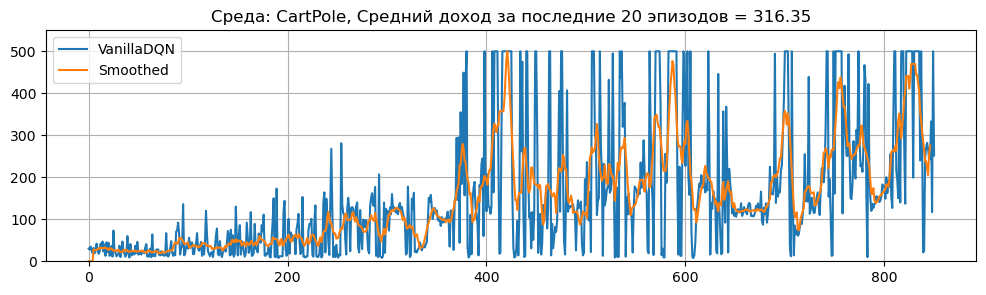

In [48]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(0, 550)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("CartPole", returns, 'VanillaDQN')

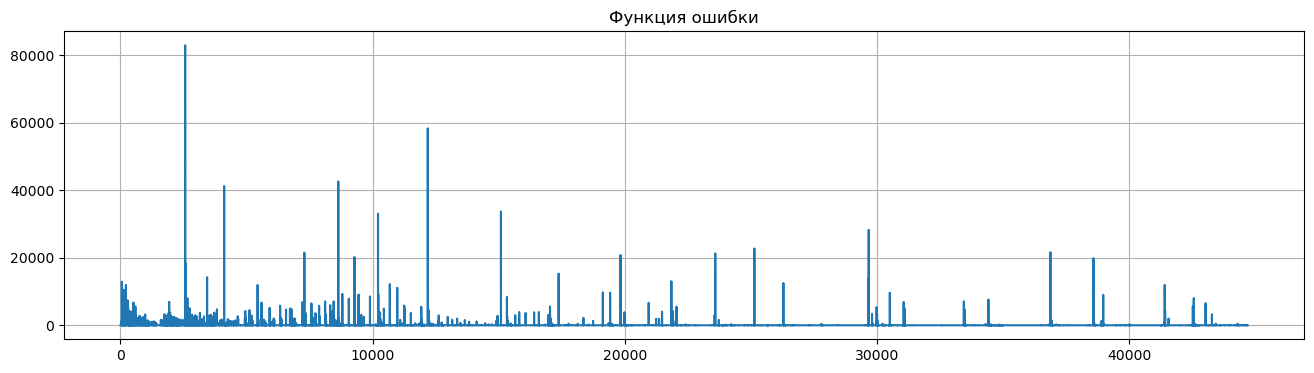

In [110]:
fig = plt.figure(figsize=(16, 4))
plt.title("Функция ошибки")
plt.plot(agent.losses)
plt.grid()
plt.show()

Ниже можно запустить 100 эпизодов симуляции работы обученного агента.

In [54]:
# можно подгрузить обученные веса
agent = DQNAgent(env, model, alpha=0.01)
agent.load_model('savedModels/CartPole_VanillaDQN_64neurons.pkl')

Model loaded


In [56]:
# создание экземпляра среды
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.39it/s]

Средний доход:  500.0
Минимальный доход:  500.0


In [52]:
# демонстрация работы агента
env = gym.make('CartPole-v1', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]

Число шагов: 246.0


# Пример 2

Рассмотрим задачу о посадке лунного модуля. У модуля есть 3 двигателя, которые он может включать или выключать. Таким образом модулю имеет 4 действия:

    0 ничего не делать
    1. включить левый двигатель
    2. включить центральный двигатель
    3. включить правый двигатель

Топливо бесконечное. Пространство состояний представляет собой 8-ми мерный вектор, каждая координата отвечает за следующие величины

    0. положение по оси Ox
    1. положение по оси Oy
    2. линейная скорость по оси Ox
    3. линейная скорость по оси Oy
    4. угол отклонения оси модуля от вертикали
    5. скорость изменения угла
    6. флаг о касании Луны левой ноги модуля
    7. флаг о касании Луны правой ноги модуля
    
Вознаграждение даётся за каждый временной шаг.

    вознаграждение увеличивается/уменьшается за сближение/удаление с посадочной площадкой
    вознаграждение увеличивается/уменьшается за более медленное/быстрое движение
    вознаграждение уменьшается за сильное отклонения угла от нулевого.
    вознаграждение увеличивается на 10 за конкакт одной ноги с поверхностью
    вознаграждение уменьшается на 0.03 за каждый временной шаг работы боковых двигателей
    вознаграждение уменьшается на 0.3 за каждый временной шаг работы центрального двигателей

За успешную посадку даётся +100. За разбитый модулю даётся -100.
Задача считается завершённой с числом очков равным 200.

Начальное состояние в положениии вверху по центру кадра со случайной начальной силой, приложенной к центру масс. 

Эпизод завершается, если модуль коснулся поверхностью не ногами (то есть модуль разбился), или если модуль улетел за допустимую область.

По ссылке в описании среды можно также дополнительно активировать ряд условий, таких как наличие ветра, изменённой гравитации, турбулентность и пр.
https://gymnasium.farama.org/environments/box2d/lunar_lander/

Для установки на Win:
    
    надо установить Microsoft Visual C++ 2014 или выше, Windows SDK для соответствующей версии Windows
    далее, надо установить бибилотеки swig и box2d-py, это можно сделать командами:
    pip install swig
    pip install box2d-py

In [58]:
env = gym.make('LunarLander-v3')

print('Размерность вектора состояний: ', env.observation_space.shape[0])
print('Количество действий: ', env.action_space.n)

Размерность вектора состояний:  8
Количество действий:  4


Поскольку в сравнении с задачей о маятнике, здесь вектор состояний больше и число действией больше, то используем сеть, где в скрытом слое 128 нейронов.


In [60]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        return self.fc2(x)
    
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

In [66]:
env = gym.make('LunarLander-v3')
env = gym.wrappers.RecordEpisodeStatistics(env, 3000)

agent = DQNAgent(env, model, alpha=0.003)

In [68]:
s, _ = env.reset()
print(s)

agent.get_action(s)

[ 0.0046073   1.3985218   0.46665055 -0.5510431  -0.00533188 -0.10570333
  0.          0.        ]


0

In [70]:
gains = DQN_control(env, agent, goal_score = 200);

Доход: -158.45 в эпизоде 0
--- 0.09579920768737793 сек ---
Доход: -192.02 в эпизоде 50
--- 5.399566888809204 сек ---
Доход: -173.60 в эпизоде 100
--- 6.409865856170654 сек ---
Доход: -147.91 в эпизоде 150
--- 7.505936861038208 сек ---
Доход: -131.95 в эпизоде 200
--- 13.64353084564209 сек ---
Доход: -114.17 в эпизоде 250
--- 20.320682287216187 сек ---
Доход: -81.90 в эпизоде 300
--- 30.936307191848755 сек ---
Доход: -9.74 в эпизоде 350
--- 30.50246548652649 сек ---
Доход: 71.77 в эпизоде 400
--- 34.39805340766907 сек ---
Доход: 92.78 в эпизоде 450
--- 29.59487247467041 сек ---
Доход: 64.78 в эпизоде 500
--- 32.62654376029968 сек ---
Доход: 47.49 в эпизоде 550
--- 32.05436873435974 сек ---
Доход: 31.31 в эпизоде 600
--- 30.72487187385559 сек ---
Доход: 53.03 в эпизоде 650
--- 34.49318838119507 сек ---
Доход: 115.12 в эпизоде 700
--- 27.039722442626953 сек ---
Доход: 137.83 в эпизоде 750
--- 25.953624963760376 сек ---
Доход: 164.16 в эпизоде 800
--- 19.9241361618042 сек ---
Доход: 184.80

In [76]:
agent.save_model("LunarLander_VanillaDQN_128neurons")

Net saved to:  savedModels/LunarLander_VanillaDQN_128neurons.pkl


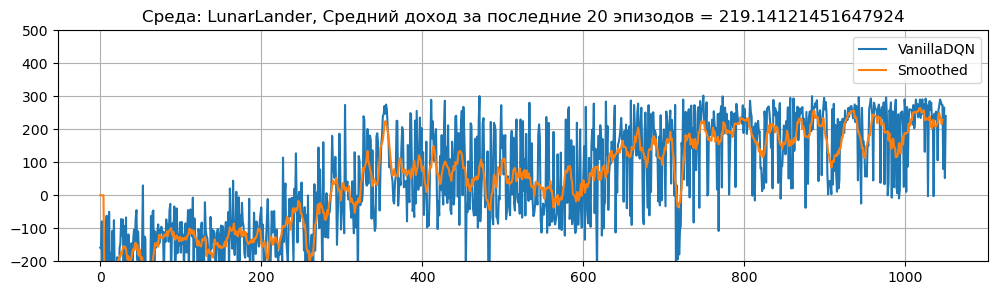

In [72]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-200,500)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("LunarLander", returns, 'VanillaDQN')

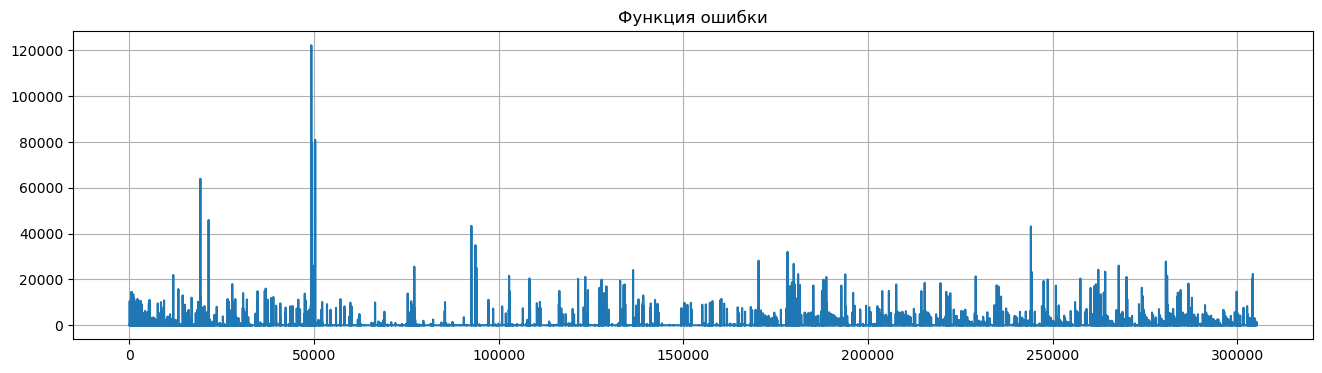

In [52]:
fig = plt.figure(figsize=(16, 4))
plt.title("Функция ошибки")
plt.plot(agent.losses)
plt.grid()
plt.show()

Ниже можно запустить 100 эпизодов симуляции работы обученного агента.

In [78]:
# можно подгрупзить обученные веса
agent = DQNAgent(env, model, alpha=0.01)
agent.load_model("savedModels/LunarLander_VanillaDQN_128neurons.pkl")

Model loaded


In [80]:
# создание экземпляра среды
env = gym.make('LunarLander-v3')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.43it/s]

Средний доход:  198.85843258646742
Минимальный доход:  -35.45808031632046


Запуск симуляции с обученным агентом.

In [82]:
# создание экземпляра среды
env = gym.make('LunarLander-v3', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]

Число шагов: 44.616260075103355


### Пример 3.

Рассмотрим задачу о машинке и холме MountainCar. Структуру ИНС используем ту же самую.

In [84]:
env = gym.make('MountainCar-v0', max_episode_steps=500)
env = gym.wrappers.RecordEpisodeStatistics(env, 2000)

print('Размерность вектора состояний: ', env.observation_space.shape[0])
print('Количество действий: ', env.action_space.n)

Размерность вектора состояний:  2
Количество действий:  3


In [86]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 96)
        self.fc2 = nn.Linear(96, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        return self.fc2(x)
    
model = QNetwork(env.observation_space.shape[0], env.action_space.n)

In [88]:
agent = DQNAgent(env, model, alpha=0.05)

In [90]:
s, _ = env.reset()
print(s)

agent.get_action(s)

[-0.40593436  0.        ]


1

In [92]:
gains = DQN_control(env, agent, num_episodes=2000, eps_start=1.0, eps_decay = 0.999, goal_score = -130)

Доход: -500.00 в эпизоде 0
--- 0.5156204700469971 сек ---
Доход: -500.00 в эпизоде 50
--- 25.084474325180054 сек ---
Доход: -500.00 в эпизоде 100
--- 24.735900163650513 сек ---
Доход: -500.00 в эпизоде 150
--- 24.73086905479431 сек ---
Доход: -500.00 в эпизоде 200
--- 25.116440057754517 сек ---
Доход: -500.00 в эпизоде 250
--- 24.983219623565674 сек ---
Доход: -500.00 в эпизоде 300
--- 25.053059101104736 сек ---
Доход: -500.00 в эпизоде 350
--- 25.07095742225647 сек ---
Доход: -500.00 в эпизоде 400
--- 25.133817434310913 сек ---
Доход: -500.00 в эпизоде 450
--- 25.45998191833496 сек ---
Доход: -500.00 в эпизоде 500
--- 25.45694065093994 сек ---
Доход: -500.00 в эпизоде 550
--- 25.321290969848633 сек ---
Доход: -500.00 в эпизоде 600
--- 25.37217950820923 сек ---
Доход: -500.00 в эпизоде 650
--- 25.247512578964233 сек ---
Доход: -500.00 в эпизоде 700
--- 25.459969997406006 сек ---
Доход: -500.00 в эпизоде 750
--- 25.449971914291382 сек ---
Доход: -500.00 в эпизоде 800
--- 25.384146690368

Как видно из печатаемой информации, обучение агента в этой задаче не достигает успеха. Действительно, здесь система вознаграждений весьма скудная и не позволяет агенту, обучаемому по методу DQN, выявить правильные действия.

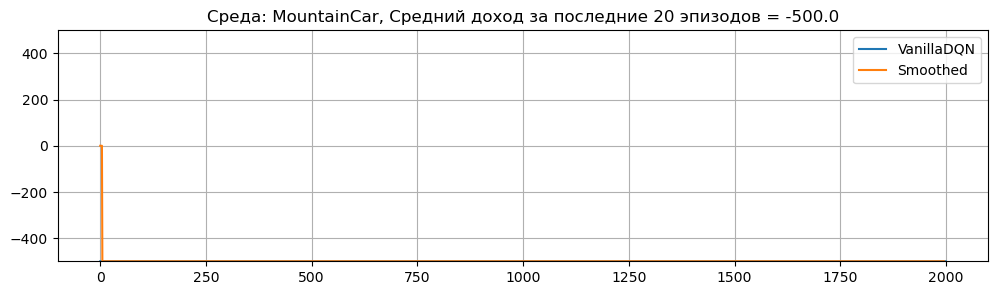

In [96]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-500,500)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("MountainCar", returns, 'VanillaDQN')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.48it/s]

Средний доход:  -500.0
Минимальный доход:  -500.0


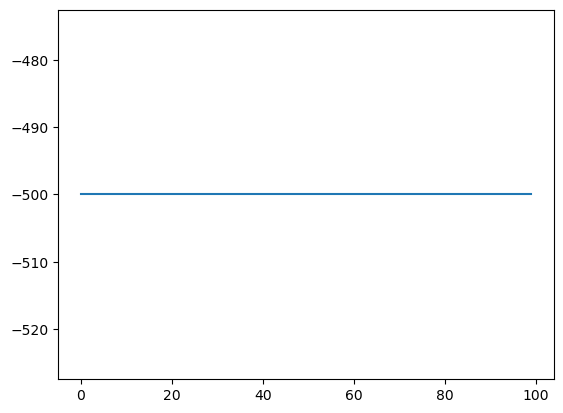

In [16]:
env = gym.make('MountainCar-v0', max_episode_steps=500)
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

In [17]:
# создание экземпляра среды
env = gym.make('MountainCar-v0', render_mode='human')
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env,1)
print("Число шагов:", env.return_queue[-1])

env.close()

Доход: -200.0
